# 6.6 Sourcing & Analyzing Time-Series Data

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing libraries and data

In [182]:
import quandl
import nasdaqdatalink
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [183]:
# Configure API key 

nasdaqdatalink.ApiConfig.api_key = '7PsdxmFMCBuvuHsP1cBN'

In [184]:
# Import the "Organization of the Petroleum Exporting Countries" data

data = nasdaqdatalink.get_table('QDL/OPEC')

In [185]:
data.head(5)

,date,value
None,,
0,2024-01-25,81.98
1,2024-01-24,81.05
2,2024-01-23,81.30
3,2024-01-22,79.70
4,2024-01-19,80.27


In [186]:
data.shape

(5435, 2)

In [187]:
data.columns

Index(['date', 'value'], dtype='object')

In [188]:
type(data)

pandas.core.frame.DataFrame

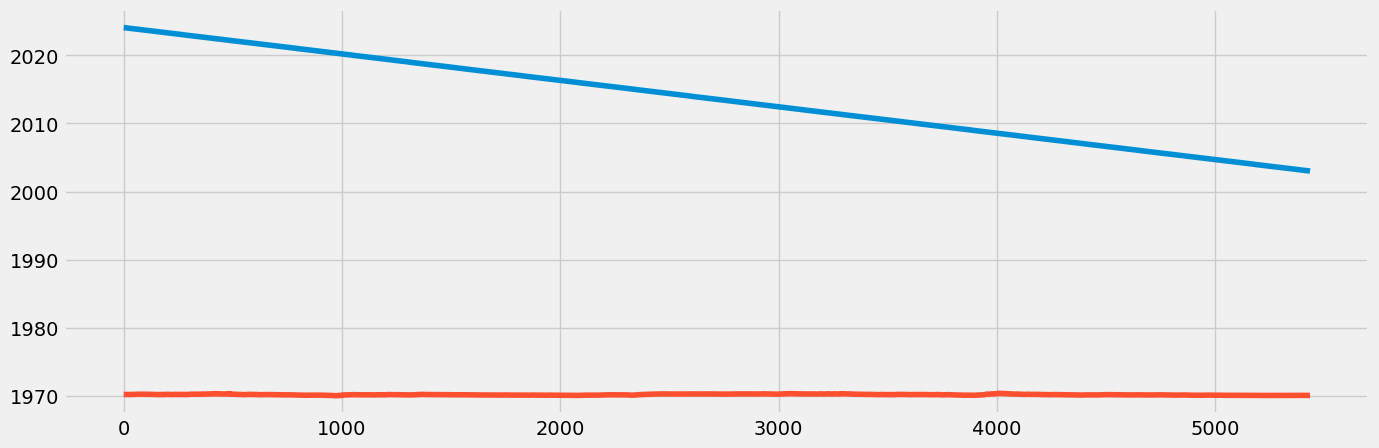

In [189]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [190]:
# Reset index so that the "date" column can be used as a filter

data_2 = data.reset_index()

In [191]:
data_2.head()

,None,date,value
0,0,2024-01-25,81.98
1,1,2024-01-24,81.05
2,2,2024-01-23,81.30
3,3,2024-01-22,79.70
4,4,2024-01-19,80.27


In [192]:
data_2.drop('None', axis=1, inplace=True)

In [193]:
data_2.tail()

,date,value
5430,2003-01-08,28.86
5431,2003-01-07,29.72
5432,2003-01-06,30.71
5433,2003-01-03,30.83
5434,2003-01-02,30.05


In [194]:
# Create subset showing only for the year 2023

data_sub = data_2.loc[(data_2['date'] >= '2023-01-01') & (data_2['date'] < '2023-12-31')]

In [195]:
data_sub.shape

(257, 2)

In [196]:
data_sub.head()

,date,value
18,2023-12-29,78.44
19,2023-12-28,80.31
20,2023-12-27,81.82
21,2023-12-26,80.71
22,2023-12-22,81.23


In [197]:
# Set the "date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['date']) # Create a datetime column from "date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['date'], axis=1, inplace=True) # Drop the "date" column.
data_sub.head()

,value
datetime,
2023-12-29,78.44
2023-12-28,80.31
2023-12-27,81.82
2023-12-26,80.71
2023-12-22,81.23


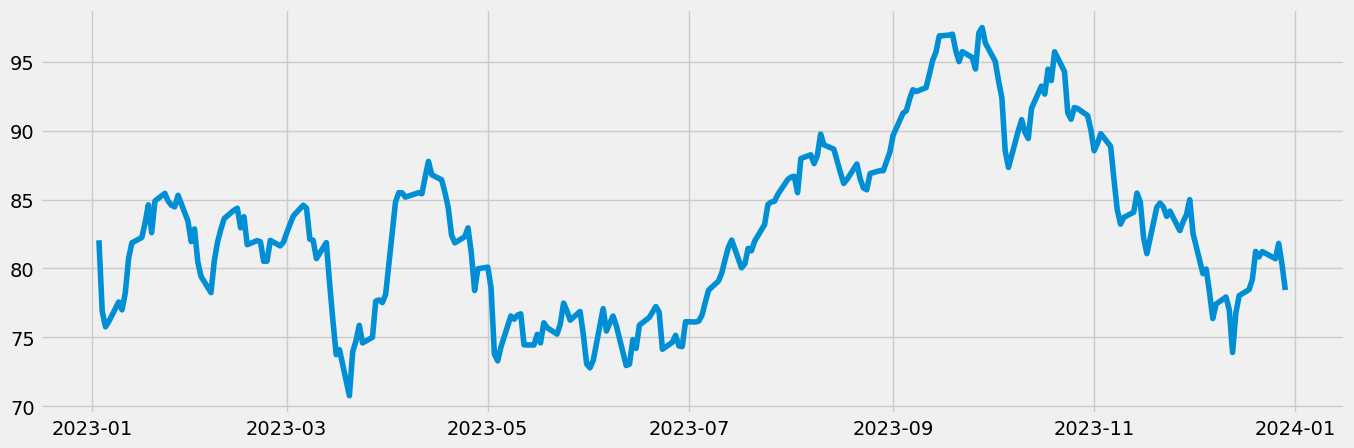

In [198]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [199]:
# Check for missing values
data_sub.isnull().sum() 

value    0
dtype: int64

In [200]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()


12

In [201]:
data_sub = data_sub.drop_duplicates()

In [202]:
dups = data_sub.duplicated()
dups.sum()

0

In [217]:
# Sort the date to ascending

data_sub = data_sub.sort_index(ascending=True)

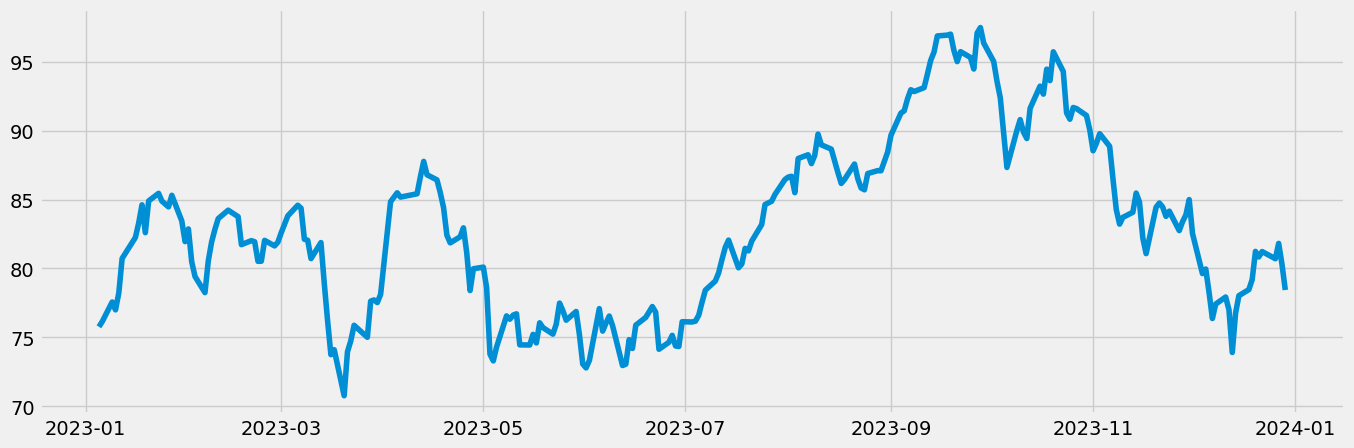

In [218]:
# Plot the cleaned data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

### 3. Time-series analysis: decomposition

In [255]:
# Decompose the time series using additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive', period = 12)

In [256]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

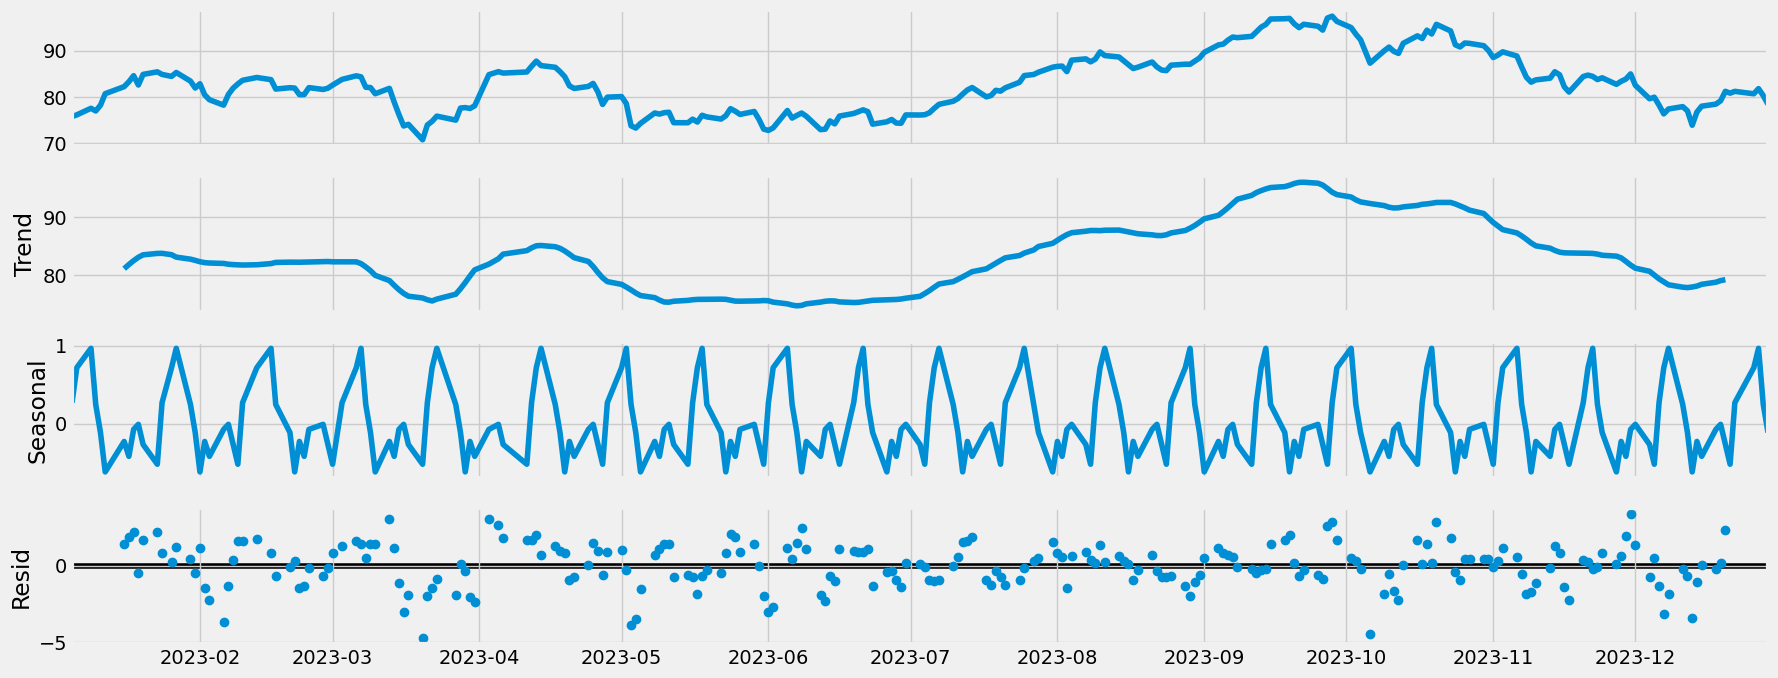

In [257]:
# Plot the separate components

decomposition.plot()
plt.show()

The second panel shows the trend component. This smooths out the long-term movement in the data. From the graph, it is evident that there are  fluctuations from February to May, followed by a decline until November, and then a slight upward movement towards December 2023.

For the seasonal component, there is a clear and consistent pattern repeating approximately two times per month. This indicates a strong seasonal effect with a regular cycle.

The residuals in the bottom panel appear to be randomly scattered around zero, suggesting that the decomposition has effectively captured the trend and seasonal components.

### 4. Testing for stationarity

In [258]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.865973
p-value                          0.348234
Number of Lags Used              5.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


Since the p-value (0.348234) is greater than all the provided critical values (most commonly used are 1% and 5%), the result fails to reject the null hypothesis. This means the test doesn't provide statistically significant evidence against stationarity.

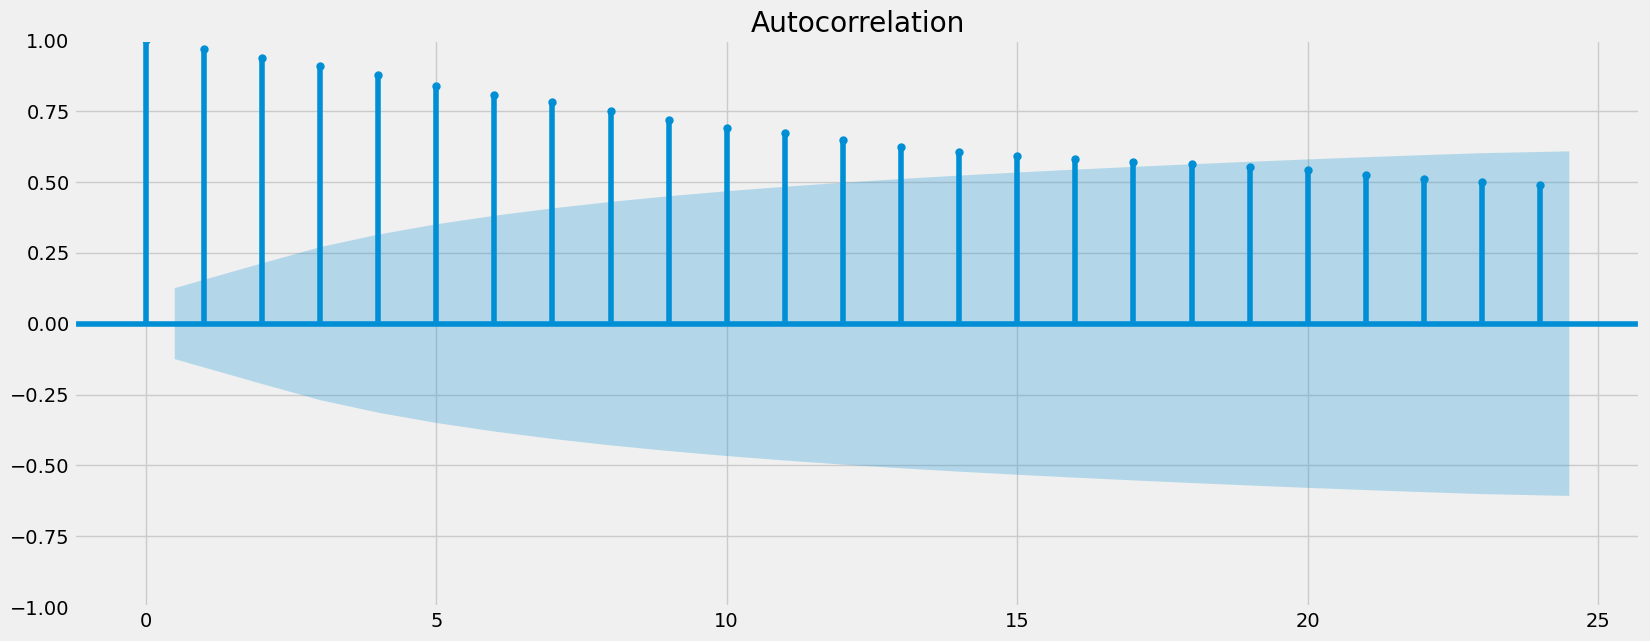

In [259]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the Federal Reserve Economic Data

In [260]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [261]:
data_diff.dropna(inplace = True)

In [262]:
data_diff.head()

,value
datetime,
2023-01-06,0.38
2023-01-09,1.42
2023-01-10,-0.57
2023-01-11,1.23
2023-01-12,2.50


In [263]:
data_diff.columns

Index(['value'], dtype='object')

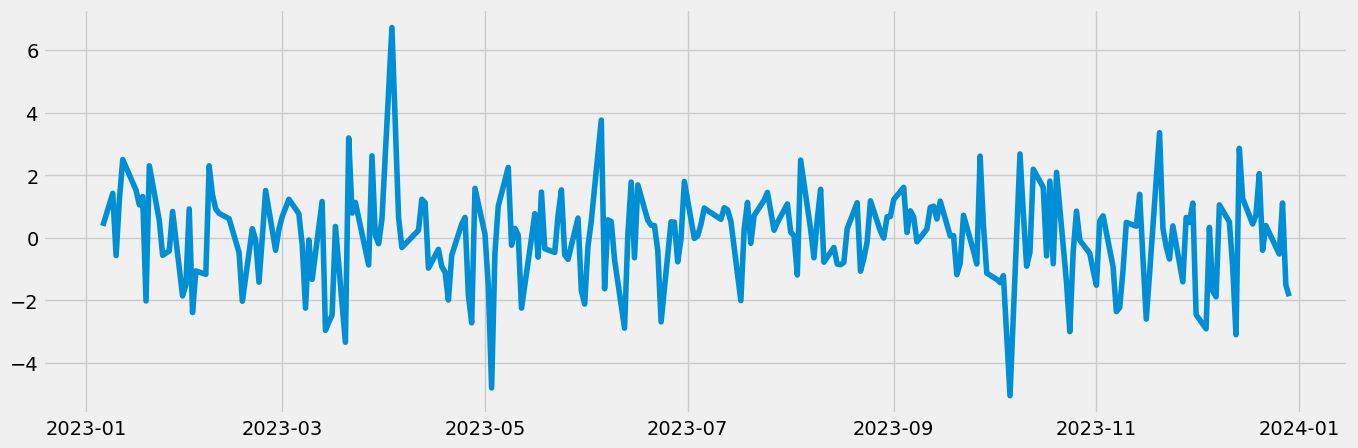

In [264]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [265]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.944073e+00
p-value                        1.007699e-09
Number of Lags Used            4.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


The test statistic (-6.944) is smaller than the critical value (-2.873) at both 5% and 10%. However, the p-value being 1.008 meaning that we fail to reject the null hypothesis. This result is still inconclusive about the stationary of the data.

In [295]:
# Perform another round of differencing

data_diff2 = data_diff - data_diff.shift(1)
data_diff2.dropna(inplace = True)
data_diff2.head()

,value
datetime,
2023-01-09,1.04
2023-01-10,-1.99
2023-01-11,1.80
2023-01-12,1.27
2023-01-16,-0.98


In [296]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -7.913916e+00
p-value                        3.881762e-12
Number of Lags Used            1.000000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


The test statistic is getting smaller but the p-value is getting bigger.

In [297]:
# Perform another round of differencing

data_diff3 = data_diff2 - data_diff2.shift(1)
data_diff3.dropna(inplace = True)
data_diff3.head()

,value
datetime,
2023-01-10,-3.03
2023-01-11,3.79
2023-01-12,-0.53
2023-01-16,-2.25
2023-01-17,0.51


Dickey-Fuller Stationarity test:
Test Statistic                -9.296747e+00
p-value                        1.140724e-15
Number of Lags Used            1.200000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


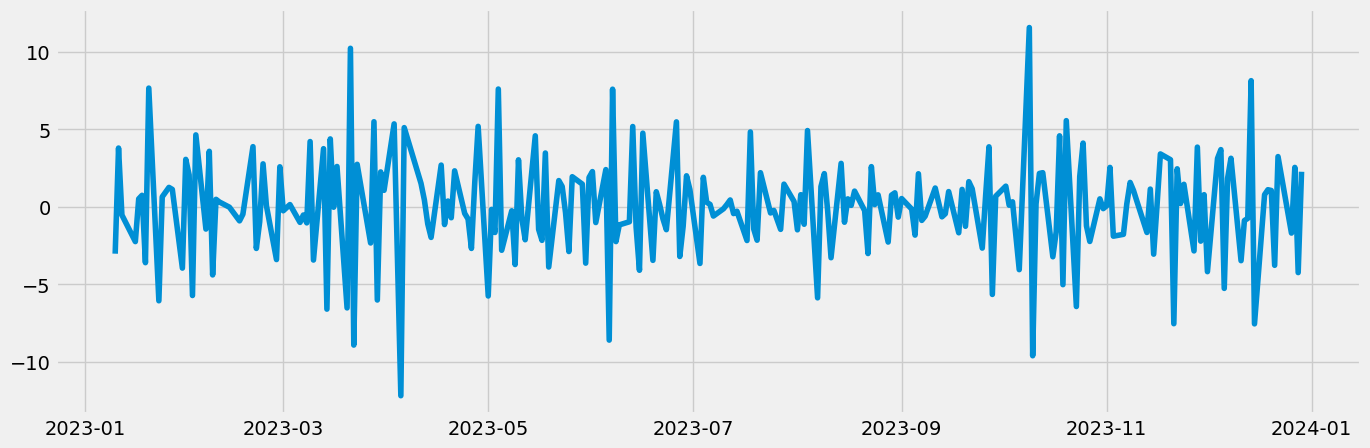

In [298]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff3)

dickey_fuller(data_diff3)

After a total of 3 round of differencing made, the small negative test statistic leans towards rejecting the null hypothesis (data might be stationary).

However, the large p-value (1.14) suggests that the observed test statistic is not statistically significant. There's a high probability of seeing such a value by chance, even if the data were truly non-stationary.

This combination indicates that the evidence against non-stationarity (the small test statistic) is weak and not statistically convincing based on the large p-value. Hence, the stationary status of this data is inconclusive.